In [2]:
# import libraries needed
import pandas as pd
import numpy as np
import random

import codecs
from SmilesPE.tokenizer import *
from SmilesPE.pretokenizer import atomwise_tokenizer
from SmilesPE.pretokenizer import kmer_tokenizer

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data

Import cleaned and standardized data for the Tox21 NR-AhR assay.  Use train and score datasets as train and test data, respectively.

In [6]:
train = pd.read_csv('../processed_data/nr_ahr_std_train.csv')
#train.head()

train_data = train.std_compounds
train_labels = train.label

print('Train data shape:', train_data.shape)
print('Train labels shape:', train_labels.shape)

active_train = train_data[train_labels == 1].reset_index(drop=True)
inactive_train = train_data[train_labels == 0].reset_index(drop=True)

print('Active compounds:', len(train_labels[train_labels == 1]))
print('Inactive compounds:', len(train_labels[train_labels == 0]))
print('Inactive : Active ~', len(train_labels[train_labels == 0]) // len(train_labels[train_labels == 1]))

Train data shape: (6709,)
Train labels shape: (6709,)
Active compounds: 761
Inactive compounds: 5948
Inactive : Active ~ 7


In [7]:
test = pd.read_csv('../processed_data/nr_ahr_test_std.csv')
#test.head()

test_data = test.std_compounds
test_labels = test.label

print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)

print('Active compounds:', len(test_labels[test_labels == 1]))
print('Inactive compounds:', len(test_labels[test_labels == 0]))
print('Inactive : Active ~', len(test_labels[test_labels == 0]) // len(test_labels[test_labels == 1]))

Test data shape: (607,)
Test labels shape: (607,)
Active compounds: 71
Inactive compounds: 536
Inactive : Active ~ 7


### Creating SPE features

Paper reference: https://drive.google.com/file/d/1Mh-rBJS3CXt2lwsNTTEVnMReK8K4u6eR/view
GitHub site: https://github.com/XinhaoLi74/SmilesPE

Steps:
1) Load vocabulary pre-trained by the authors from CheMBL data (SPE_ChEMBL.txt).
2) Use `spe.tokenize()` to split SMILES strings in train and test data to fragments from pre-trained vocabulary.  Note that this produces another string with fragments separated by spaces.
3) Use `CountVectorizer()` to split the tokenized strings into tokens and transform each data set into a matrix of vectors.

*Note*:
- Can use `TfidfVectorizer()` instead of `CountVectorizer()`

In [10]:
def spe_featurizer(train_data, test_data):
    """Creates datasets ready to input into ML models
       Uses SPE vocabulary and CountVectorizer to create features"""
    
    # load vocab
    spe_vob = codecs.open(r'SPE_ChEMBL.txt')
    spe = SPE_Tokenizer(spe_vob)
    
    # split SMILES strings to tokens
    train_spe = train_data.apply(lambda x: spe.tokenize(x))
    test_spe = test_data.apply(lambda x: spe.tokenize(x))
    
    # split tokenized strings into tokens
    # transform dataset into a matrix of vectors
    split_string = lambda x: x.split()
    vectorizer = CountVectorizer(preprocessor=None, stop_words=None, lowercase=False, tokenizer=split_string)

    x_train = vectorizer.fit_transform(train_spe)
    x_test = vectorizer.transform(test_spe)
    train_vocab = vectorizer.get_feature_names()
    
    return x_train, x_test, train_vocab

In [14]:
x_spe, x_spe_test, spe_vocab = spe_featurizer(train_data, test_data)

print(x_spe.shape)
print(x_spe_test.shape)

(6709, 2378)
(607, 2378)


In [26]:
def spe_featurizer2(train_data, test_data):
    """Creates datasets ready to input into ML models
       Uses SPE vocabulary and CountVectorizer to create features
       Forces the use of whole vocabulary, not just fragments in train data"""
    
    # load vocab
    spe_vocab = pd.read_csv('SPE_ChEMBL.txt', header=None)
    spe_vocab = spe_vocab.rename(columns={0: 'fragments'})
    
    spe_vob = codecs.open(r'SPE_ChEMBL.txt')
    spe = SPE_Tokenizer(spe_vob)
    
    # split SMILES strings to tokens
    train_spe = train_data.apply(lambda x: spe.tokenize(x))
    test_spe = test_data.apply(lambda x: spe.tokenize(x))
    
    # split tokenized strings into tokens
    # transform dataset into a matrix of vectors
    split_string = lambda x: x.split()
    vectorizer = CountVectorizer(preprocessor=None, stop_words=None, lowercase=False, 
                                 tokenizer=split_string, vocabulary=spe_vocab.fragments)
    x_train = vectorizer.transform(train_spe)
    x_test = vectorizer.transform(test_spe)
    train_vocab = vectorizer.get_feature_names()
    
    return x_train, x_test, train_vocab

In [27]:
x_spe2, x_spe2_test, spe2_vocab = spe_featurizer2(train_data, test_data)

print(x_spe2.shape)
print(x_spe2_test.shape)

(6709, 3002)
(607, 3002)


### Creating atom-wise and k-mer features

See GitHub site for creating SPE features.  The authors also included an atomwise and k-mer tokenizer.

In [28]:
def atom_featurizer(train_data, test_data):
    """Creates datasets ready to input into ML models
       Uses atomwise tokenizer and CountVectorizer to create features"""
    
    # split SMILES strings into tokens
    train_atom = train_data.apply(lambda x: ' '.join(atomwise_tokenizer(x)))
    test_atom = test_data.apply(lambda x: ' '.join(atomwise_tokenizer(x)))
    
    split_string = lambda x: x.split()
    vectorizer = CountVectorizer(preprocessor=None, stop_words=None, 
                                 lowercase=False, tokenizer=split_string)

    x_train = vectorizer.fit_transform(train_atom)
    x_test = vectorizer.transform(test_atom)
    train_vocab = vectorizer.get_feature_names()
    
    return x_train, x_test, train_vocab

In [29]:
x_atom, x_atom_test, atom_vocab = atom_featurizer(train_data, test_data)

print(x_atom.shape)
print(x_atom_test.shape)

(6709, 131)
(607, 131)


In [32]:
def kmer_featurizer(train_data, test_data):
    """Creates datasets ready to input into ML models
       Uses atomwise tokenizer a
       nd CountVectorizer to create features"""
    
    # split SMILES strings into tokens
    train_kmer = train_data.apply(lambda x: ' '.join(kmer_tokenizer(x)))
    test_kmer = test_data.apply(lambda x: ' '.join(kmer_tokenizer(x)))
    
    split_string = lambda x: x.split()
    vectorizer = CountVectorizer(preprocessor=None, stop_words=None, 
                                 lowercase=False, tokenizer=split_string)

    x_train = vectorizer.fit_transform(train_kmer)
    x_test = vectorizer.transform(test_kmer)
    train_vocab = vectorizer.get_feature_names()
    
    return x_train, x_test, train_vocab

In [33]:
x_kmer, x_kmer_test, kmer_vocab = kmer_featurizer(train_data, test_data)

print(x_kmer.shape)
print(x_kmer_test.shape)

(6709, 7831)
(607, 7831)


### Running and evaluating models

Prints three types of evaluation for models:
- Classification report that includes accuracy, precision, and F1 score ([link](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9) to blog post explanation)
- ROC-AUC score ([link](https://youtu.be/4jRBRDbJemM) to good video explanation)
- Confusion matrix

In [38]:
def run_model(classifier, classifier_name, x_train, x_test):
    """Helper function for running and evaluating models"""
    
    trained_classifier = classifier.fit(x_train, train_labels)
    
    # print classification report for model 
    report = classification_report(test_labels, trained_classifier.predict(x_test))
    print(report)
    
    # print roc-auc score for model
    roc_auc = roc_auc_score(test_labels, trained_classifier.predict_proba(x_test)[:, 1])
    print(f'ROC-AUC: {roc_auc:.3f}')
    
    # show a confusion matrix for the model
    disp = plot_confusion_matrix(trained_classifier, x_test, test_labels, cmap='cividis')
    disp.figure_.suptitle(f'Confusion Matrix for {classifier_name} Model')
    plt.show()

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       536
           1       0.39      0.51      0.44        71

    accuracy                           0.85       607
   macro avg       0.66      0.70      0.68       607
weighted avg       0.87      0.85      0.86       607

ROC-AUC: 0.835


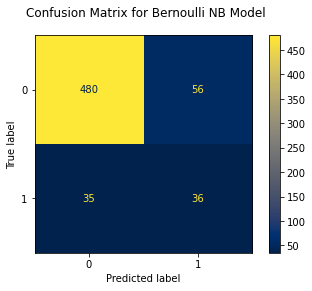

In [42]:
classifier = BernoulliNB()
run_model(classifier, 'Bernoulli NB', x_spe, x_spe_test)

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       536
           1       0.35      0.10      0.15        71

    accuracy                           0.87       607
   macro avg       0.62      0.54      0.54       607
weighted avg       0.83      0.87      0.84       607

ROC-AUC: 0.628


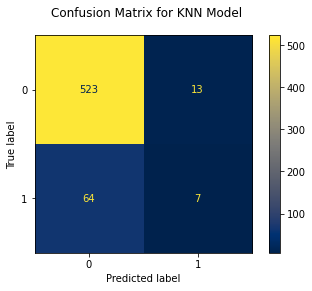

In [43]:
classifier = KNeighborsClassifier(n_neighbors=5)
run_model(classifier, 'KNN', x_spe, x_spe_test)

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       536
           1       0.35      0.11      0.17        71

    accuracy                           0.87       607
   macro avg       0.62      0.54      0.55       607
weighted avg       0.83      0.87      0.84       607

ROC-AUC: 0.825


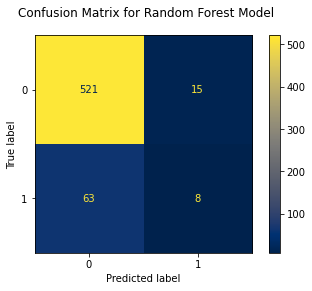

In [44]:
classifier = RandomForestClassifier()
run_model(classifier, 'Random Forest', x_spe, x_spe_test)

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       536
           1       0.44      0.38      0.41        71

    accuracy                           0.87       607
   macro avg       0.68      0.66      0.67       607
weighted avg       0.86      0.87      0.87       607

ROC-AUC: 0.786


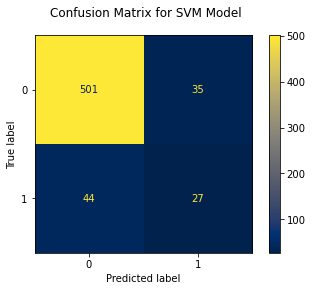

In [47]:
classifier = SVC(probability=True, kernel='linear')
run_model(classifier, 'SVM', x_spe, x_spe_test)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       536
           1       0.42      0.42      0.42        71

    accuracy                           0.86       607
   macro avg       0.67      0.67      0.67       607
weighted avg       0.86      0.86      0.86       607

ROC-AUC: 0.791


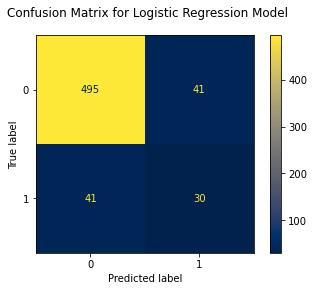

In [48]:
classifier = LogisticRegression(C=10, solver="liblinear", multi_class="auto")
run_model(classifier, 'Logistic Regression', x_spe, x_spe_test)